In [48]:
%matplotlib inline

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [109]:
mat = scipy.io.loadmat('distrib.mat')
uniform = mat['uniform']
normal = mat['normal']
laplacian = mat['laplacian']

A = np.array([[4,3],[2,1]])

In [194]:
def plot_dataset(data, title='', xlabel='Source 1', ylabel='Source 2'):
    df = pd.DataFrame(data.T, columns=[xlabel, ylabel])
#     g = sns.jointplot(x=xlabel, y=ylabel, data=df)
#     sns.plt.suptitle(title, fontsize=20, y=1.08)

In [211]:
def procedure(s):
    #Plot the original sources
    plot_dataset(s, title='Original sources')
    
    #7.3a - Apply mixing matrix A and plot mixed data
    x = np.dot(A,s)
    plot_dataset(x, title='After mixing', xlabel='Mixed 1', ylabel='Mixed 2')
    
    #7.3b - Center to mean 0 and plot centered data
    x = x - np.mean(x,axis=1).reshape(2,1)
    plot_dataset(x, title='After centering', xlabel='Centered 1', ylabel='Centered 2')
    
    #7.3c - Decorrelate by PCA and project onto the principal components
    # (consult: 1. eig vs eigh 2. should we sort eigvals?)
    covmat = np.cov(x)
    eigvals, eigvecs = np.linalg.eig(covmat)

In [212]:
procedure(normal)

eigh
 [  0.20219106  45.4666799 ] 

 [[ 0.40440258 -0.91458108]
 [-0.91458108 -0.40440258]]



eig
 [ 45.4666799    0.20219106] 

 [[ 0.91458108 -0.40440258]
 [ 0.40440258  0.91458108]]


In [ ]:
def kurtosis_of_dist(s):
    x = np.dot(A,s)
    x -= np.mean(x)

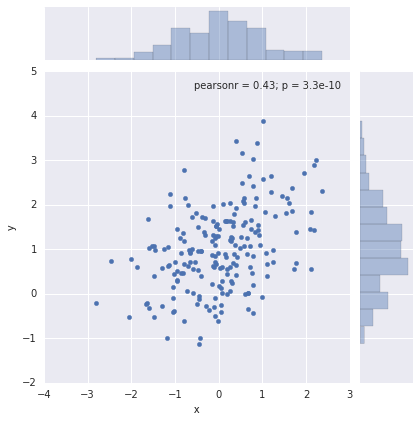

In [45]:

# sns.set(color_codes=True)


# mean, cov = [0, 1], [(1, .5), (.5, 1)]
# data = np.random.multivariate_normal(mean, cov, 200)
# df = pd.DataFrame(data, columns=["x", "y"])

# sns.jointplot(x="x", y="y", data=df);